# Tutorial 06: CommonRoad Curvilinear Coordinatesystem

This tutorial shows you how to create a **curvilinear coordinate system** using CommonRoad scenarios.
The curvilinear coordinate system is aligned with a given reference path. Any point (x,y) in the cartesian frame is described by the coordinates (s,d) in the curvilinear frame,
where s is the arc length along the reference path and d the lateral deviation to the reference path.

Before starting this tutorial, make sure that you have gone through the tutorial for CommonRoad-IO and have installed all necessary dependencies according to the installation manual.

This tutorial further requires the [commonroad-route-planner](https://gitlab.lrz.de/tum-cps/commonroad-route-planner): Please make sure you have installed the code according to the installation description
in the repository.

## 1. Preparation
We begin by importing all required modules for this tutorial.

In [1]:
%matplotlib inline
import os

import numpy as np
import matplotlib.pyplot as plt

# commonroad-io imports
from commonroad.common.file_reader import CommonRoadFileReader
from commonroad.visualization.mp_renderer import MPRenderer
from commonroad.scenario.lanelet import Lanelet

# commonroad-dc imports
from commonroad_dc.pycrccosy import CurvilinearCoordinateSystem
from commonroad_dc.geometry.util import chaikins_corner_cutting, resample_polyline

# commonroad-route-planner imports
from commonroad_route_planner.route_planner import RoutePlanner
from commonroad_route_planner.utility.visualization import visualize_route

## 2. Load CommonRoad scenario
We load the CommonRoad scenario for which we want to create a curvilinear coordinate system.

In [2]:
# load the CommonRoad scenario, note that you might have to modify the path to the CommonRoad scenario!
file_path = os.path.join(os.getcwd(), 'others/scenario_8.xml')

scenario, planning_problem_set = CommonRoadFileReader(file_path).open()
# retrieve the first planning problem in the problem set
planning_problem = list(planning_problem_set.planning_problem_dict.values())[0]

## 3. Create a reference path for the coordinate system
We need to generate a reference path to construct the curvilinear coordinate system. A reference path can be any polyline, e.g., the centerline of a lanelet or a route obtained with a route planner.

In this tutorial we generate a reference path by creating a route from the initial position to the goal region using the commonroad-route-planner.
For more details regarding the usage of the route planner, please refer to the [route-planner tutorial](https://gitlab.lrz.de/tum-cps/commonroad-route-planner/-/blob/main/tutorial/tutorial_route_planner.ipynb).

In [3]:
# instantiate a route planner with the scenario and the planning problem
route_planner = RoutePlanner(scenario, planning_problem, backend=RoutePlanner.Backend.NETWORKX_REVERSED)

# plan routes, and save the routes in a route candidate holder
candidate_holder = route_planner.plan_routes()

# option 1: retrieve all routes
list_routes, num_route_candidates = candidate_holder.retrieve_all_routes()
print(f"Number of route candidates: {num_route_candidates}")
# here we retrieve the first route in the list, this is equivalent to: route = list_routes[0]
route = candidate_holder.retrieve_first_route()
ref_path = route.reference_path

Number of route candidates: 3


We visualize the scenario and the reference path of the generated route.

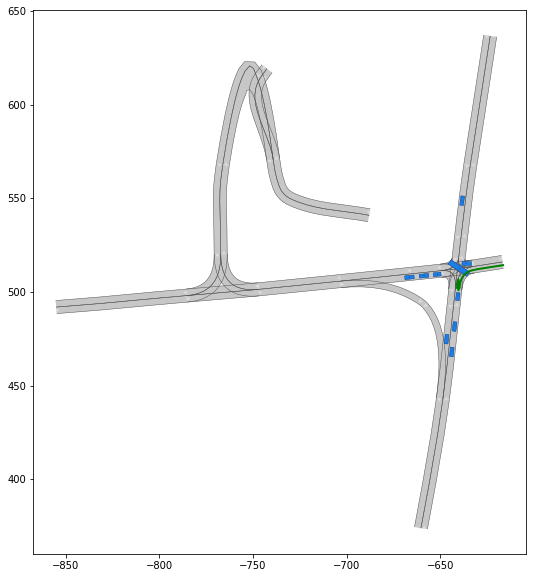

In [4]:
# draw scenario
rnd = MPRenderer(figsize=(25, 10))
scenario.draw(rnd, draw_params={'time_begin': 30, 'scenario': {
        'lanelet_network': {'lanelet': {'show_label': False,}}}})
planning_problem_set.draw(rnd)
rnd.render()

# draw reference path
plt.plot(ref_path[:, 0], ref_path[:, 1], zorder=100, linewidth=2, color='green')

## 4. Create the curvilinear coordinate system

We preprocess the reference path before creating the coordinate system: We smoothen the polyline using Chaikins corner cutting algorithm
followed by resampling of the polyline every 2m. Then, we are able to create the curvilinear coordinate system based on
the preprocessed reference path.

In [5]:
# we apply chaikins corner cutting 10 times to smoothen the reference path
for i in range(0, 10):
    ref_path = chaikins_corner_cutting(ref_path)
ref_path = resample_polyline(ref_path, 2.0)

# create curvilinear CoSy
curvilinear_cosy = CurvilinearCoordinateSystem(ref_path, 25.0, 0.1)

## 5. Project position onto curvilinear frame

Now, we can convert coordinates from the Cartesian frame to the curvilinear coordinate system and vice versa.

In [6]:
# original cartesian point
# p_cartesian = np.array([25, 0.1])

# convert to curvilinear coordinates
# p_curvilinear = curvilinear_cosy.convert_to_curvilinear_coords(p_cartesian[0], p_cartesian[1])
# print('Converted p_cartesian in curvilinear coordinates: {}'.format(p_curvilinear))

# back-convert to cartesian coordinates
# p_cartesian = curvilinear_cosy.convert_to_cartesian_coords(p_curvilinear[0], p_curvilinear[1])
# print('Back-converted p_curvilinear in cartesian coordinates: {}'.format(p_cartesian))


Below, we visualize the unique projection domain of the curvilinear coordinate system as well as the projection of a
point onto the reference path. The projection domain describes the area around the reference path, in which any point can uniquely be converted from the cartesian frame to the curvilinear frame and vice versa.

The function `project_and_plot` projects a given cartesian position onto the curvilinear
frame and visualizes the projection.

In [7]:
def project_and_plot(ccosy, position):
    print(f"Orginal position: {position}")

#     p_curvilinear = ccosy.convert_to_curvilinear_coords(position[0], position[1])
#     print(f"Converted curvilinear position: {p_curvilinear}")

#     p_cartesian = ccosy.convert_to_cartesian_coords(p_curvilinear[0], p_curvilinear[1])
#     print(f"Back-converted cartesian position: {p_cartesian}")

#     projected_point = ccosy.convert_to_cartesian_coords(p_curvilinear[0], 0)
#     print(f"Projected point on the reference path: {projected_point}")
    projected_point = [-600, 500]

    # visualize
    rnd = MPRenderer(figsize=(25, 10))
    # draw scenario
    scenario.draw(rnd, draw_params={'time_begin': 0, 'scenario': {
            'lanelet_network': {'lanelet': {'show_label': False, 'draw_line_markings':False}}},
            'dynamic_obstacle':{'trajectory':{'draw_trajectory':False},
                                'draw_shape': False}})
    planning_problem_set.draw(rnd)
    rnd.render()
    # draw reference path
    rp = np.asarray(ccosy.reference_path())
    plt.plot(rp[:, 0], rp[:, 1], zorder=100, marker='.', color='green')

    # draw projection of point
    plt.plot([position[0], projected_point[0]], [position[1], projected_point[1]], zorder=100, linewidth=2, marker='x',
             markersize=9, color='red')

    # draw projection domain
    proj_domain_border = np.asarray(ccosy.projection_domain())
    plt.plot(proj_domain_border[:, 0], proj_domain_border[:, 1], zorder=100, color='orange')

We can now project any given cartesian point. The projection of the cartesian point is shown in red and the projection
domain is shown in orange.

Orginal position: [-1000  -820]


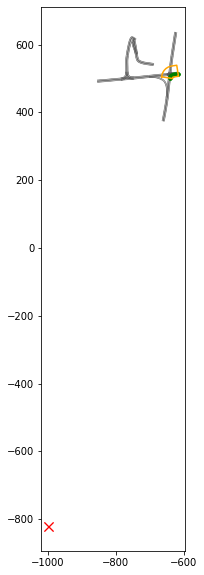

In [8]:
cartesian_point = np.array([-600, 500])
project_and_plot(curvilinear_cosy, cartesian_point)

## 6. Compute curvature of reference path

In certain cases it might be necessary to obtain the curvature of the reference path. We can
directly compute the curvature for each point of the polyline as follows.
The curvature of the reference path is returned as a list.

In [9]:
# compute the curvature of the reference path and set it
curvilinear_cosy.compute_and_set_curvature()

# return the curvature of the reference path as a list
print(curvilinear_cosy.get_curvature())

[-5.164496792260473e-06, -2.5822483932610476e-06, 0.008128985357664516, -0.04335266481627749, -0.0317168976712622, -0.06314931560887371, -0.08508497411012042, -0.10596976849979535, -0.12048155806456527, -0.10830189042746806, -0.06256831537799128, -0.024098655472913948, -0.008558449387340334, -0.002482231257618096, -0.00023699451441185293, -9.516120450951153e-08, -3.386329876519043e-08, -3.288651883801453e-09, -3.4624205389745416e-14, -4.700944303330647e-13, -0.00293789862430184, -5.616500885267786e-06]
